<a href="https://colab.research.google.com/github/ced-sys/AI-N-ML/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
plt.style.use('default')
sns.set_palette("husl")

In [6]:
df=pd.read_csv('loan_approval_dataset.csv')
print(f"Dataset loaded successfully!")
print(f'Dataset shape: {df.shape}')
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully!
Dataset shape: (1000, 8)
Columns: ['income', 'credit_score', 'employment_years', 'loan_amount', 'age', 'has_criminal_record', 'debt_to_income_ratio', 'approved']


In [7]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
income                  0
credit_score            0
employment_years        0
loan_amount             0
age                     0
has_criminal_record     0
debt_to_income_ratio    0
approved                0
dtype: int64


In [8]:
if 'approved' in df.columns:
  approval_rate=df['approved'].mean()
  print(f"\nApproval rate: {approval_rate:.2%}")
  print(f"Total approved: {df['approved'].sum()}")
  print(f"Total rejected: {len(df)-df['approved'].sum()}")


Approval rate: 41.70%
Total approved: 417
Total rejected: 583


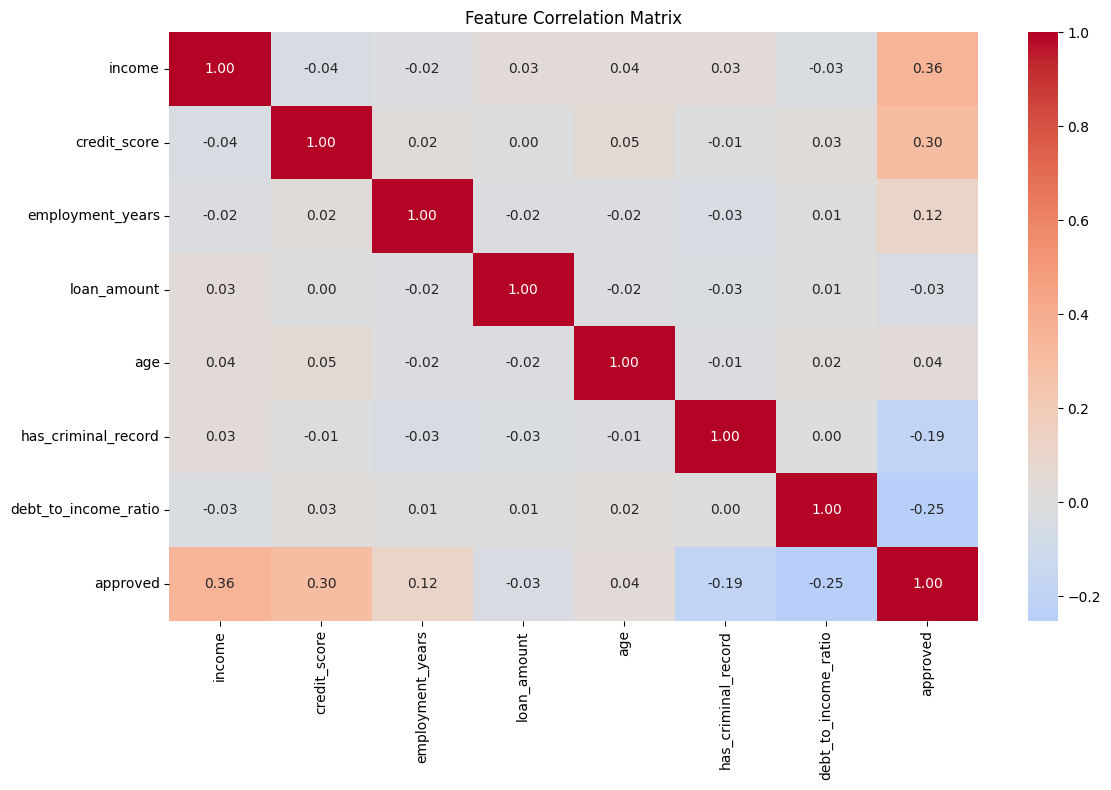

In [9]:
plt.figure(figsize=(12, 8))
correlation_matrix=df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

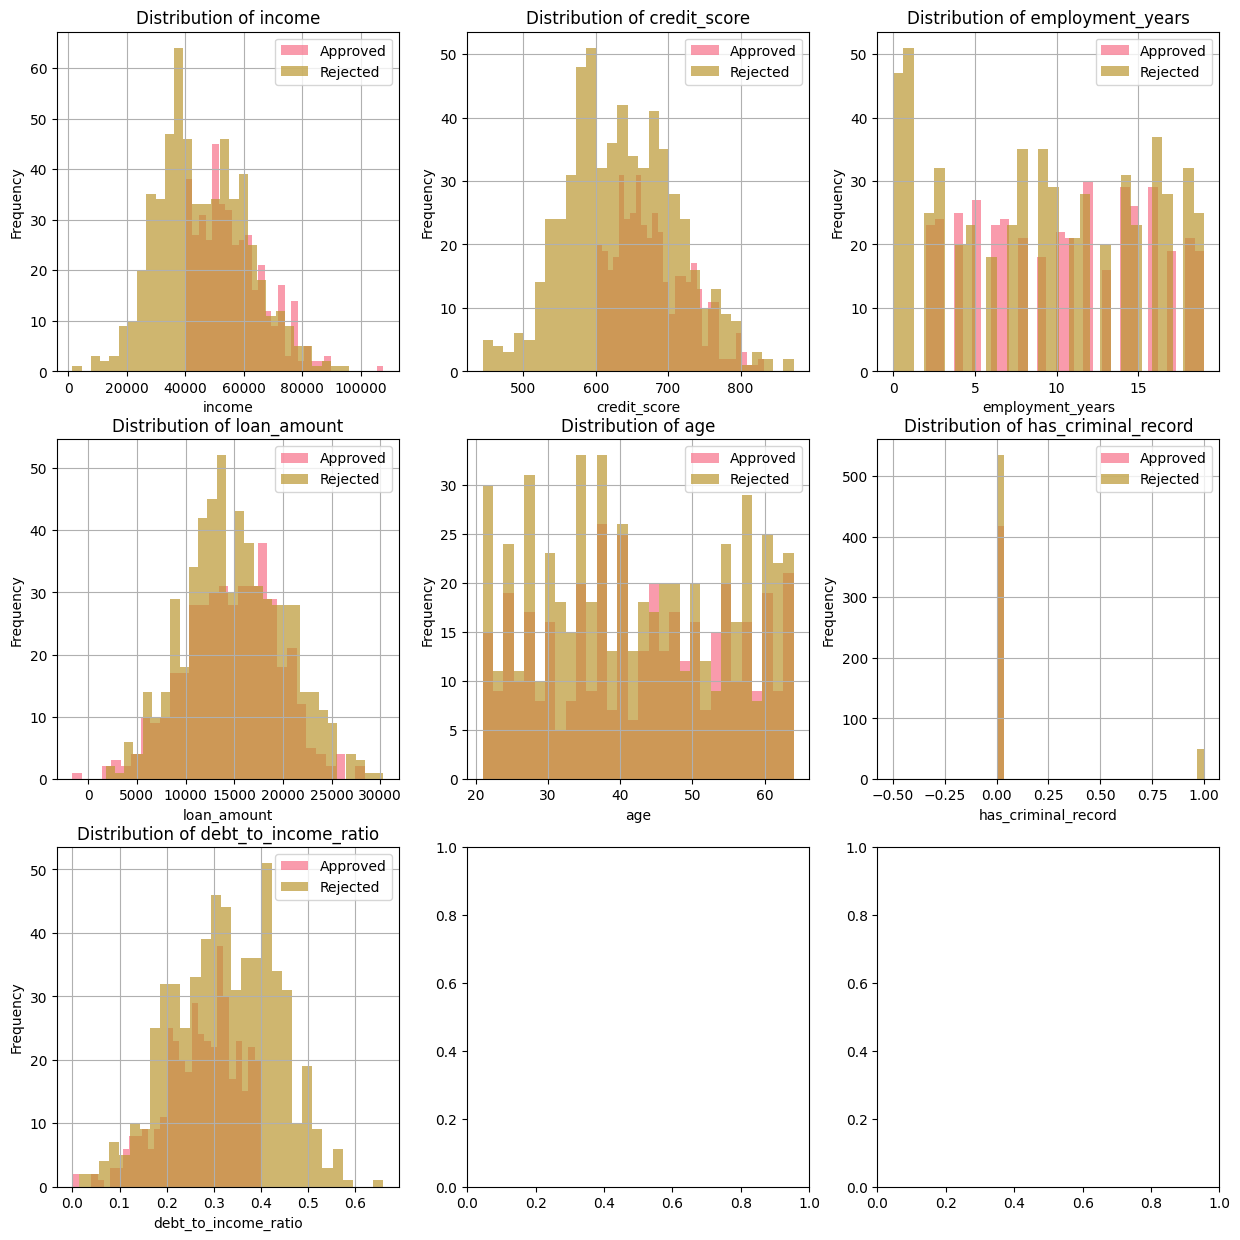

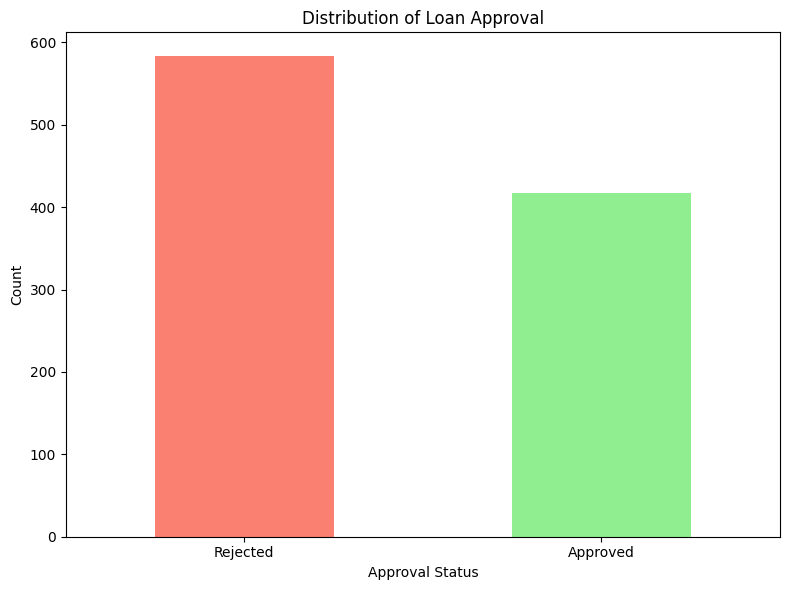

In [10]:
target_column='approved'
numerical_features=df.select_dtypes(include=[np.number]).columns.tolist()
if target_column in numerical_features:
  numerical_features.remove(target_column)

if len(numerical_features)>0:
  n_cols=3
  n_rows=(len(numerical_features)+n_cols-1) // n_cols

  fig, axes=plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
  if n_rows==1:
    axes=axes.reshape(1, -1)

  for i, feature in enumerate(numerical_features):
    row, col=i // n_cols, i% n_cols
    ax=axes[row, col]

    if target_column in df.columns:
      df[df[target_column]==1][feature].hist(alpha=0.7, label="Approved", bins=30, ax=ax)
      df[df[target_column]==0][feature].hist(alpha=0.7, label='Rejected', bins=30, ax=ax)
      ax.legend()
    else:
      df[feature].hist(bins=30, ax=ax)

    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

if target_column in df.columns:
  plt.figure(figsize=(8, 6))
  df[target_column].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'])
  plt.title('Distribution of Loan Approval')
  plt.xlabel('Approval Status')
  plt.ylabel('Count')
  plt.xticks([0, 1], ['Rejected', 'Approved'], rotation=0)
  plt.tight_layout()
  plt.show()

In [13]:
X=df.drop(target_column, axis=1)
y=df[target_column]

print(f"Final feature set shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Final feature set shape: (1000, 7)
Features: ['income', 'credit_score', 'employment_years', 'loan_amount', 'age', 'has_criminal_record', 'debt_to_income_ratio']


In [14]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f'Test set size: {X_test.shape[0]}')

Training set size: 800
Test set size: 200


In [16]:
models={
    'Shallow Tree (max_depth=4)': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Medium Tree (max_depth=8)': DecisionTreeClassifier(max_depth=8, random_state=42),
    'Deep Tree (no limit)': DecisionTreeClassifier(random_state=42),
    'Pruned Tree (min_samples_split=20)': DecisionTreeClassifier(min_samples_split=20, random_state=42),
    'Balanced Tree': DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=42)
}

results={}
for name, model in models.items():
  print(f"Training {name}...")

  model.fit(X_train, y_train)

  y_pred_train=model.predict(X_train)
  y_pred_test=model.predict(X_test)

  train_accuracy=accuracy_score(y_train, y_pred_train)
  test_accuracy=accuracy_score(y_test, y_pred_test)

  results[name]={
      'model': model,
      'train_accuracy': train_accuracy,
      'test_accuracy': test_accuracy,
      'predictions': y_pred_test
  }

  print(f"Training accuracy: {train_accuracy:.4f}")
  print(f" Test accuracy:{test_accuracy:.4f}")
  print(f"Overfitting: {train_accuracy-test_accuracy:.4f}")

Training Shallow Tree (max_depth=4)...
Training accuracy: 0.9675
 Test accuracy:0.9800
Overfitting: -0.0125
Training Medium Tree (max_depth=8)...
Training accuracy: 0.9988
 Test accuracy:0.9850
Overfitting: 0.0138
Training Deep Tree (no limit)...
Training accuracy: 1.0000
 Test accuracy:0.9850
Overfitting: 0.0150
Training Pruned Tree (min_samples_split=20)...
Training accuracy: 0.9950
 Test accuracy:0.9900
Overfitting: 0.0050
Training Balanced Tree...
Training accuracy: 0.9850
 Test accuracy:0.9900
Overfitting: -0.0050


Best model: Pruned Tree (min_samples_split=20)
Test acuracy: 0.9900

Detailed analysis of Pruned Tree (min_samples_split=20):

Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      0.98      0.99       117
    Approved       0.98      1.00      0.99        83

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



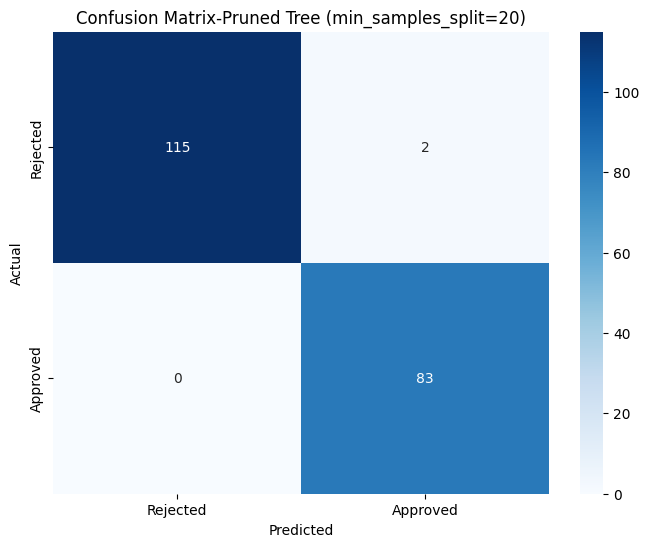

In [21]:
best_model_name=max(results.keys(), key=lambda k: results[k]['test_accuracy'])
best_model=results[best_model_name]['model']
best_predictions=results[best_model_name]['predictions']

print(f"Best model: {best_model_name}")
print(f"Test acuracy: {results[best_model_name]['test_accuracy']:.4f}")

print(f"\nDetailed analysis of {best_model_name}:")

print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=['Rejected', 'Approved']))

plt.figure(figsize=(8, 6))
cm=confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title(f'Confusion Matrix-{best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

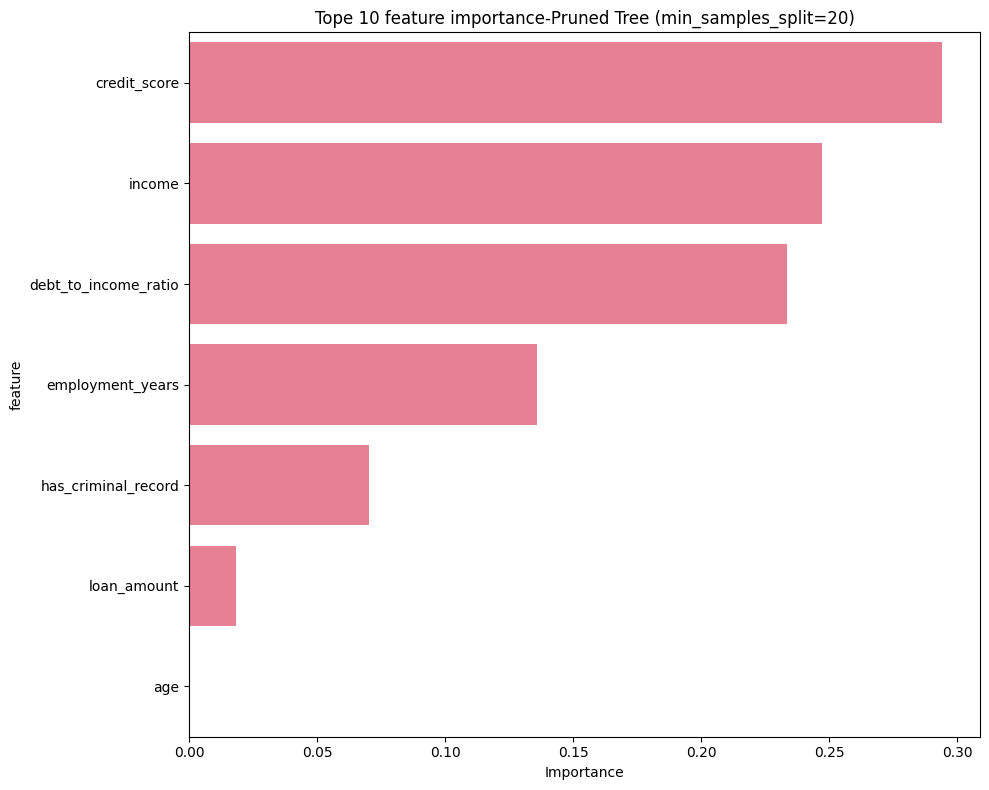


Top 10 most importanct features:
                feature  importance
1          credit_score    0.294231
0                income    0.247423
6  debt_to_income_ratio    0.233729
2      employment_years    0.135864
5   has_criminal_record    0.070373
3           loan_amount    0.018380
4                   age    0.000000


In [22]:
feature_importance=pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features=feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(f'Tope 10 feature importance-{best_model_name}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 most importanct features:")
print(feature_importance.head(10))

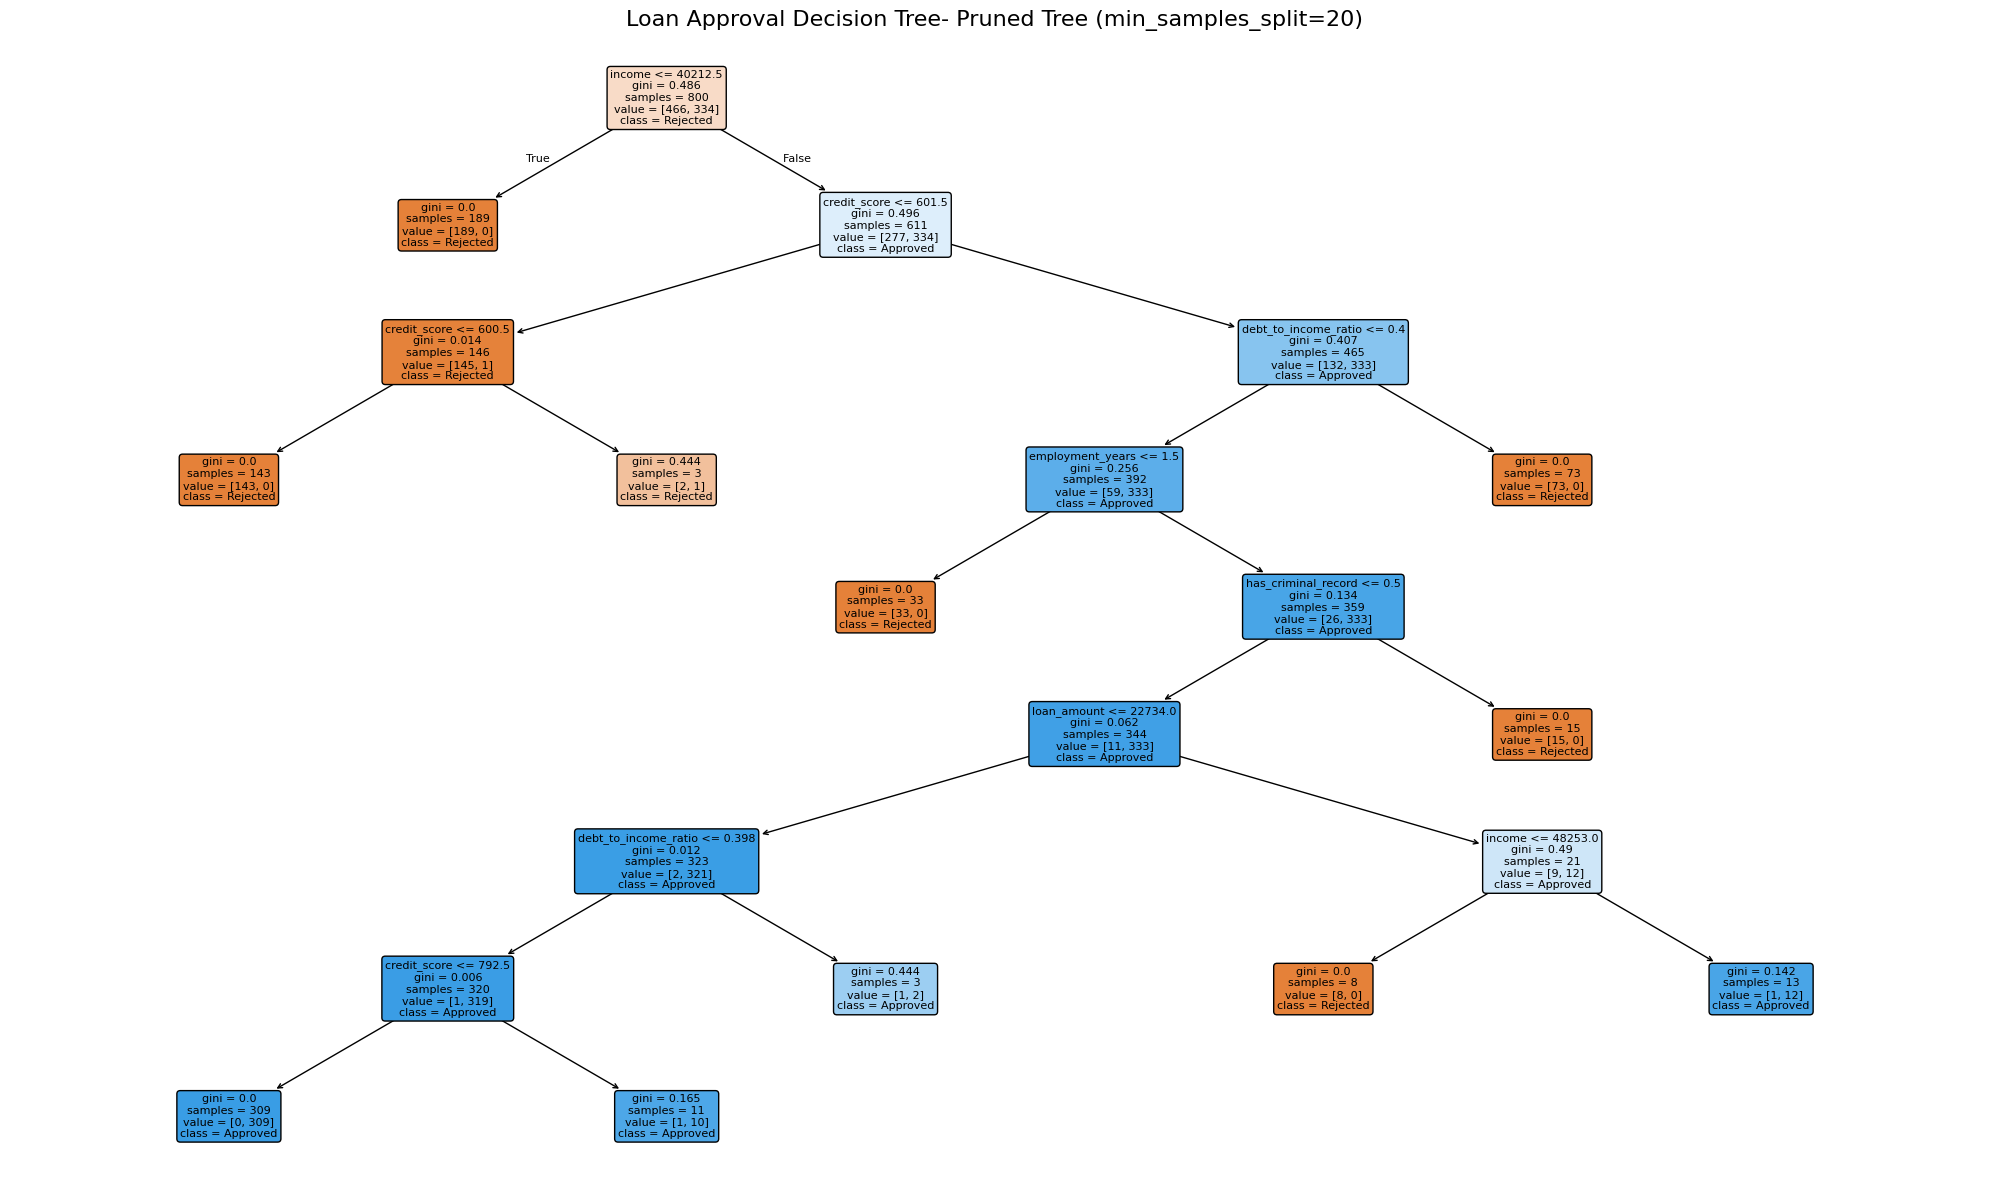

In [24]:
plt.figure(figsize=(20, 12))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=['Rejected', 'Approved'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title(f"Loan Approval Decision Tree- {best_model_name}", fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
print(f"\nDecision Tree Rules for {best_model_name}:")
tree_rules=export_text(best_model, feature_names=list(X.columns))
print(tree_rules)


Decision Tree Rules for Pruned Tree (min_samples_split=20):
|--- income <= 40212.50
|   |--- class: 0
|--- income >  40212.50
|   |--- credit_score <= 601.50
|   |   |--- credit_score <= 600.50
|   |   |   |--- class: 0
|   |   |--- credit_score >  600.50
|   |   |   |--- class: 0
|   |--- credit_score >  601.50
|   |   |--- debt_to_income_ratio <= 0.40
|   |   |   |--- employment_years <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- employment_years >  1.50
|   |   |   |   |--- has_criminal_record <= 0.50
|   |   |   |   |   |--- loan_amount <= 22734.00
|   |   |   |   |   |   |--- debt_to_income_ratio <= 0.40
|   |   |   |   |   |   |   |--- credit_score <= 792.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- credit_score >  792.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- debt_to_income_ratio >  0.40
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- loan_amount >  22734.00
|   |   |   |   |   